In [2]:
!pip install -qU transformers torch datasets


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import matplotlib.pyplot as plt

In [3]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

c:\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Dataset - Conceptual_Captions

In [4]:
image_data = load_dataset(
    "conceptual_captions", split="train",
    )

No config specified, defaulting to: conceptual_captions/unlabeled
Found cached dataset conceptual_captions (/home/ubuntu/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


In [ ]:
image_data_df = pd.DataFrame(image_data[:100])

In [7]:
"""
Not all the URLs are valid. This function returns True if the URL is valid. False otherwise. 
"""
def check_valid_URLs(image_URL):

    try:
      response = requests.get(image_URL)
      Image.open(BytesIO(response.content))
      return True
    except:
      return False

def get_image(image_URL):

    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    return image

def get_image_caption(image_ID):

    return image_data[image_ID]["caption"]

In [ ]:
# Transform dataframe
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)

In [ ]:
image_data_df = image_data_df[image_data_df["is_valid"]==True]
image_data_df.head()

In [ ]:
image_data_df["image"] = image_data_df["image_url"].apply(get_image)

### Dataset - Coco Data - 2014 -- Project 2

In [8]:
import json

In [9]:
f = open(r'D:\git\CLIP_prefix_caption\data\coco\annotations\train_caption.json')
coco_data = json.load(f)

In [10]:
data_dict = {'image_id':[],'image':[],'caption':[]}

In [1]:
limit = 10000

In [30]:
for i in range(len(coco_data)):
    if i == limit:
        break
    d = coco_data[i]
    img_id = d["image_id"]
    filename = f"D:/git/CLIP_prefix_caption/data/coco/train2014/COCO_train2014_{int(img_id):012d}.jpg"
    if not os.path.isfile(filename):
        filename = f"D:/git/CLIP_prefix_caption/data/coco/val2014/COCO_val2014_{int(img_id):012d}.jpg"
    image = Image.open((filename)).convert("RGB")
    data_dict['image_id'].append(img_id)
    data_dict['image'].append(image)
    data_dict['caption'].append(d['caption'])

In [31]:
img_df = pd.DataFrame(data_dict)

### Implementation of Clip Model to do Image-to-Image Search

In [14]:

def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [15]:

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)
     

In [16]:
def get_single_text_embedding(text):
    inputs = tokenizer(text, return_tensors = "pt").to(device)
    text_embeddings = model.get_text_features(**inputs)
    # convert the embeddings to numpy array 
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

In [17]:
def get_all_text_embeddings(df, text_col):
    df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)
    return df 

In [32]:
img_df = get_all_text_embeddings(img_df, "caption")

In [ ]:
image_data_df = get_all_text_embeddings(image_data_df, "caption")

In [19]:
def get_single_image_embedding(my_image):
    image = processor(
      text = None,
      images = my_image, 
      return_tensors="pt"
  )["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

In [20]:
def get_all_images_embedding(df, img_column):
    df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
    return df

In [22]:
my_image = img_df['image'][0]

In [33]:
img_df = get_all_images_embedding(img_df, "image")

In [ ]:
image_data_df = get_all_images_embedding(image_data_df1, "image")

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values] 
  list_captions = [top_images.iloc[idx].caption for idx in index_values] 
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values] 

  n_row = n_col = 3

  _, axs = plt.subplots(n_row, n_col, figsize=(15, 15))
  [axi.set_axis_off() for axi in axs.ravel()]
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      # ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

In [23]:
from sklearn.metrics.pairwise import cosine_similarity  

In [44]:
def get_top_N_images(query, data, top_K=15, search_criterion="text"):
    # Text to image Search
    if(search_criterion.lower() == "text"):
        query_vect = get_single_text_embedding(query)

    # Image to image Search
    else: 
        query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["caption", "image", "cos_sim"]
    
    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
    
    """
    Sort Cosine Similarity Column in Descending Order 
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]
    print(most_similar_articles['cos_sim'].unique())
    
    return most_similar_articles[revevant_cols].reset_index()

### Implementation of BLIP Model

In [22]:
from transformers import AutoTokenizer,AutoProcessor

In [23]:
from transformers import Blip2ForConditionalGeneration

In [24]:
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b",torch_dtype=torch.float16)

In [25]:
blip_model= Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

For stability purposes, it is recommended to have accelerate installed when using this model in torch.float16, please install it with `pip install accelerate`


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
blip_model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [27]:
blip_tokenizer = AutoTokenizer.from_pretrained("Salesforce/blip2-opt-2.7b",torch_dtype=torch.float16)

In [28]:
pwd

'/home/ubuntu/git_repo/Clip_Image_Search_Model'

In [38]:
# Taking the stored image from Image dir
image = Image.open('image/car.jpg')

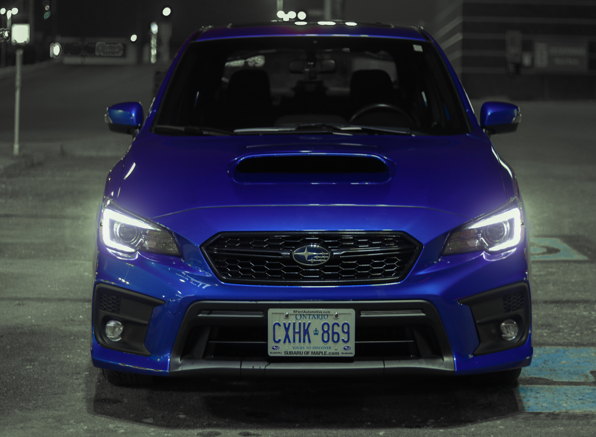

In [35]:
display(image.resize((596, 437)))

### Visual question answering using BLIP_2 model

In [40]:
prompt = "Question: which car is this ? Answer:"

inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = blip_model.generate(**inputs, max_new_tokens=10)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

subaru wrx sti


### Displaying similar images using cos similarity on the CLIP image encoding

In [ ]:
query_caption = image
top_images = get_top_N_images(query_caption, img_df,search_criterion='img')
# print("Query: {}".format(query_caption))
top_images

### Displaying images for the inputed query  --- Project 2

In [45]:
query_caption = 'snow and winter'
top_images = get_top_N_images(query_caption, img_df,search_criterion='text')
# print("Query: {}".format(query_caption))
top_images

[0.26916328 0.2558739  0.24122475 0.23734614]


,index,caption,image,cos_sim
0,1889,A cat and a dog look out of the door at a car ...,<PIL.Image.Image image mode=RGB size=480x640 a...,0.269163
1,1948,A dog and cat staring outside at the snow.,<PIL.Image.Image image mode=RGB size=480x640 a...,0.269163
2,1982,a dog and a cat sitting next to each other whi...,<PIL.Image.Image image mode=RGB size=480x640 a...,0.269163
3,1911,A dog and a cat are looking at the snowy front...,<PIL.Image.Image image mode=RGB size=480x640 a...,0.269163
4,1151,a bike leaning on the side of a house with a c...,<PIL.Image.Image image mode=RGB size=448x640 a...,0.255874
5,1162,A red bicycle parked up against a brick buildi...,<PIL.Image.Image image mode=RGB size=448x640 a...,0.255874
6,902,A bicycle with wagon propped against a building.,<PIL.Image.Image image mode=RGB size=448x640 a...,0.255874
7,1002,A bike parked on the side of a building in the...,<PIL.Image.Image image mode=RGB size=448x640 a...,0.255874
8,1029,A bicycle pulling a trailer in the snow leanin...,<PIL.Image.Image image mode=RGB size=448x640 a...,0.255874
9,1187,United Postal Service truck drives over very s...,<PIL.Image.Image image mode=RGB size=640x360 a...,0.241225


In [56]:
a = {}
print(type(a))

<class 'dict'>


#### Created function to select the distinct images from resulted dataframe -- Project 2

In [62]:
cos_sim = set()
res_data = {'index':[],'caption':[],'image':[],'cos_sim':[]}
for index, row in top_images.iterrows():
    if row['cos_sim'] in cos_sim :
        continue
    else:
        cos_sim.add(row['cos_sim'])
        res_data['index'].append(row['index'])
        res_data['caption'].append(row['caption'])
        res_data['image'].append(row['image'])
        res_data['cos_sim'].append(row['cos_sim'])
    # print(row['index'], row['caption'])

In [65]:
rs = pd.DataFrame(res_data)

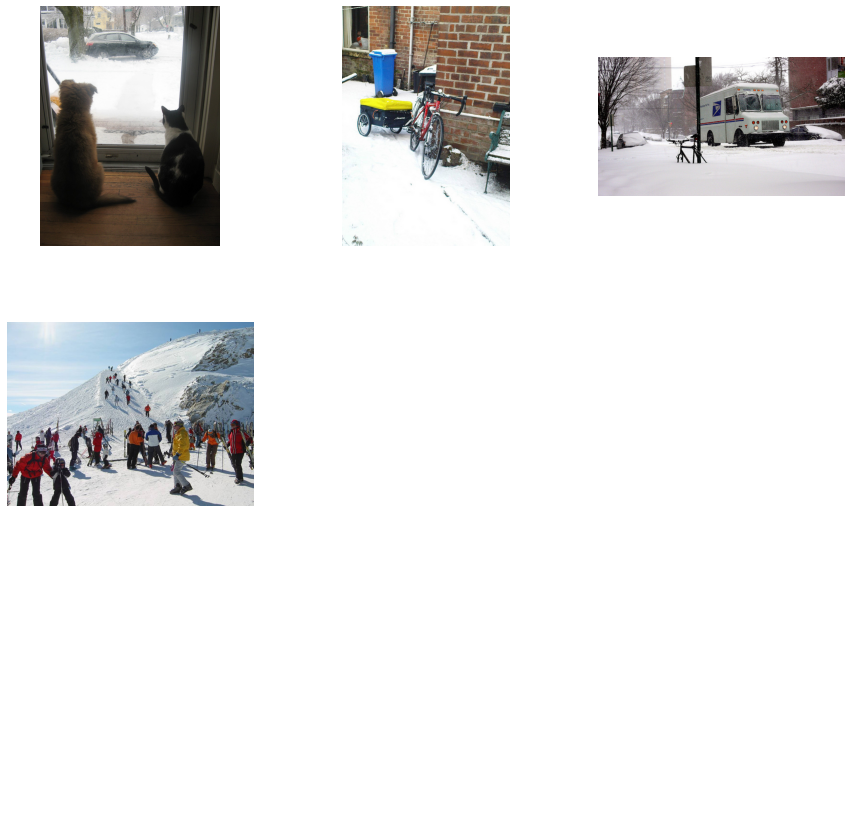

In [68]:
plot_images_by_side(rs)